In [12]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import evaluate

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE




In [4]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/ML PROJECT/Enriched_HCPCS_Descriptions.csv")

# Drop irrelevant or high-missing columns
df.drop(columns=['claim_control_number', 'Error Code'], inplace=True, errors='ignore')
df.rename(columns={'Review Decision': 'Target'}, inplace=True)

# Keep only rows with known target values
df = df[df['Target'].isin(['Agree', 'Disagree'])]

# Drop rows with null in important features
df = df[['Provider Type', 'Part', 'HCPCS Procedure Code', 'HCPCS Description', 'Target']].dropna()

# Binary target mapping
df['Target'] = df['Target'].map({'Agree': 0, 'Disagree': 1})

In [10]:
# 3-way split: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.25, random_state=42)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Train: 6612, Validation: 2205, Test: 2205


In [6]:
from sklearn.pipeline import make_pipeline

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# Logistic Regression Pipeline
log_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])

log_param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['liblinear', 'lbfgs']
}

grid_log = GridSearchCV(log_pipeline, log_param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_log.fit(X_train, y_train)

# SVM Pipeline
svc_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', SVC(probability=True))
])

svc_param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf']
}

grid_svc = GridSearchCV(svc_pipeline, svc_param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_svc.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Provider '
                                                                          'Type',
                                                                          'Part',
                                                                          'HCPCS '
                                                                          'Procedure '
                                                                          'Code',
                                                                          'HCPCS '
                                                                          'Description']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'clf__kernel': ['linear', 'rbf']},
             scoring='f1', verbose=1)

In [15]:
def evaluate(model, X, y, title="Model Evaluation"):
    y_pred = model.predict(X)
    print(f"== {title} ==")
    print(classification_report(y, y_pred))
    print(confusion_matrix(y, y_pred))


In [16]:
# Retrain best model (e.g., Logistic) on train+val
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

final_model = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(C=10, solver='liblinear', max_iter=1000))
])
final_model.fit(X_trainval, y_trainval)

# Final test evaluation
evaluate(final_model, X_test, y_test, "Logistic Regression (Test)")


== Logistic Regression (Test) ==
              precision    recall  f1-score   support

           0       0.87      0.64      0.74      1710
           1       0.35      0.68      0.46       495

    accuracy                           0.65      2205
   macro avg       0.61      0.66      0.60      2205
weighted avg       0.76      0.65      0.68      2205

[[1096  614]
 [ 160  335]]


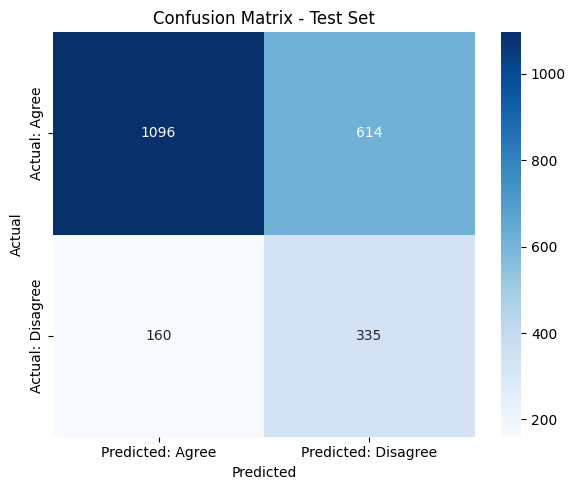

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted: Agree", "Predicted: Disagree"],
            yticklabels=["Actual: Agree", "Actual: Disagree"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


In [20]:
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)

# Extract feature importances
rf_model = rf_pipeline.named_steps['model']
encoder = rf_pipeline.named_steps['preprocess'].named_transformers_['cat']
feature_names = encoder.get_feature_names_out(categorical_cols)
importances = rf_model.feature_importances_




In [17]:
# Get predictions
y_pred = final_model.predict(X_test)

# Create a DataFrame for side-by-side comparison
comparison_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})

# Optionally decode to labels (if you prefer "Agree"/"Disagree" instead of 0/1)
label_map = {0: "Agree", 1: "Disagree"}
comparison_df["Actual_Label"] = comparison_df["Actual"].map(label_map)
comparison_df["Predicted_Label"] = comparison_df["Predicted"].map(label_map)

# Show a sample of predictions
comparison_df.sample(10, random_state=42)


,Actual,Predicted,Actual_Label,Predicted_Label
1966,0,0,Agree,Agree
1091,0,0,Agree,Agree
1468,0,0,Agree,Agree
438,0,0,Agree,Agree
1790,0,0,Agree,Agree
1953,0,0,Agree,Agree
752,0,1,Agree,Disagree
408,1,1,Disagree,Disagree
1477,0,0,Agree,Agree
2037,0,0,Agree,Agree


In [22]:
def predict_claim_outcome(model_pipeline, claim_dict):
    new_data = pd.DataFrame([claim_dict])
    pred = model_pipeline.predict(new_data)[0]
    prob = model_pipeline.predict_proba(new_data)[0][1]
    return ("Disagree" if pred == 1 else "Agree"), prob

# Example
sample = {
    "Provider Type": "Ophthalmology",
    "Part": "B",
    "HCPCS Procedure Code": "K0553",
    "HCPCS Description": "Continuous glucose monitor supplies"
}

outcome, probability = predict_claim_outcome(grid_log.best_estimator_, sample)
print(f"Outcome: {outcome}, Probability of Disagree: {probability:.2f}")


Outcome: Disagree, Probability of Disagree: 0.82
